# run_car

In [2]:
import datetime
import numpy as np
import random

In [3]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from tqdm import tqdm_notebook

In [6]:
from functools import reduce

# базовый пример кода
```
if filename:
    agent = SimpleCarAgent.from_file(filename)
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    if evaluate:
        print(w.evaluate_agent(agent, steps))
    else:
        w.set_agents([agent])
        w.run(steps)
else:
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    w.run(steps)
```

In [7]:
def create_map(seed, agent):
    np.random.seed(seed)
    random.seed(seed)
    m = generate_map(8, 5, 3, 3)
    w = SimpleCarWorld([agent], m, SimplePhysics, None, timedelta=0.2)
    return w

# Агент

Пример `agent = SimpleCarAgent.from_file('network_config_agent_0_layers_9_6_1.txt')`

# Параметры

In [8]:
map_seeds = [3, 13, 23]

In [9]:
# За сколько шагов модель начинает учитывать вознаграждение
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

In [10]:
def mine_data(agent, agent_random_action,
              clear_history, map_seed, steps,
              epochs, mini_batch_size, eta, reward_shift, clip):
    agent.RANDOM_ACTION_P = agent_random_action
    if clear_history:
        agent.clear_history()
    
    #mine data
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=tqdm_notebook(range(steps), desc="train", leave=False), visual=False, save=False)

    # prepare train data
    X_train = np.concatenate([agent.sensor_data_history, agent.chosen_actions_history], axis=1)
    y_train = np.array(agent.reward_history)
    mean_train_revard = y_train.mean()

    y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
    norm_reward_size = reward_shift * (reward_shift - 1) / 2
    y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * i / norm_reward_size
                                          for i in range(1, reward_shift+1)])

    #train NN
    train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]
    agent.neural_net.SGD(training_data=train_data,
                         epochs=epochs,
                         mini_batch_size=mini_batch_size,
                         eta=eta)
    if clip:
        for i, w in enumerate(agent.neural_net.weights):
            agent.neural_net.weights[i] = np.clip(w, -clip, clip)
        for i, b in enumerate(agent.neural_net.biases):
            agent.neural_net.biases[i] = np.clip(b, -clip, clip)   

    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"{map_seed}, {agent_random_action:.2f}, {mean_train_revard:.10f}, {mean_test_reward:.10f}"
    print(log_message)
    plt.figure(figsize=(6 * (agent.neural_net.num_layers - 1), 2))
    for l in range(agent.neural_net.num_layers - 1):
        plt.subplot(1, agent.neural_net.num_layers - 1, l+1)
        ax = sns.heatmap(agent.neural_net.weights[l])
    plt.show()


3, 1.00, -0.4629636019, -3.3428897772


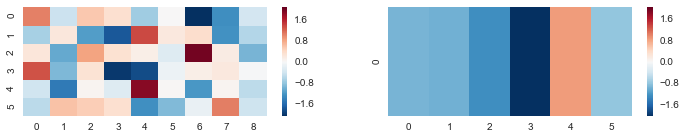

3, 0.81, -0.4802768683, -0.4847084152


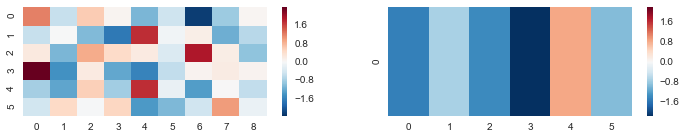

3, 0.62, -0.4291415988, -0.2057281469


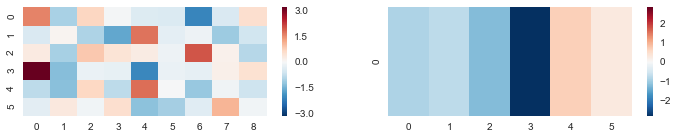

3, 0.43, -0.2738384064, -3.4776310864


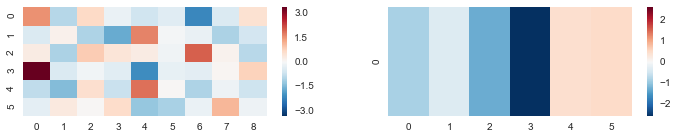

3, 0.24, -0.3630192092, -0.3859258008


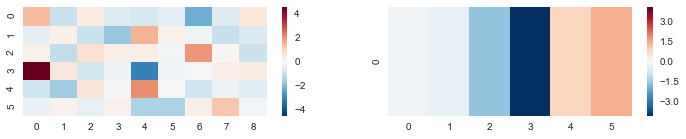

3, 0.05, -0.4490937542, -0.4134117344


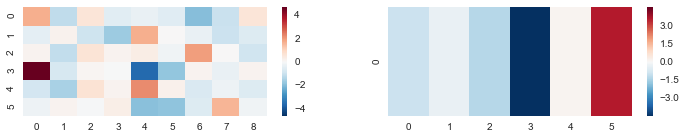

In [12]:
kvparams = {
    "clear_history": True,
    "map_seed": map_seed,
    "steps": 1000,
    "epochs": 40,
    "mini_batch_size": 50,
    "eta": 0.05,
    "reward_shift": 4,
    "clip": False
}

random.seed(42)
np.random.seed(42)
agent1 = SimpleCarAgent(name="Ivan")

for agent_random_action in tqdm_notebook(np.arange(1, 0, -.19), desc="main_1"):
    mine_data(agent1, agent_random_action, **kvparams)

3, 0.10, -0.2535421566, -0.3529261361


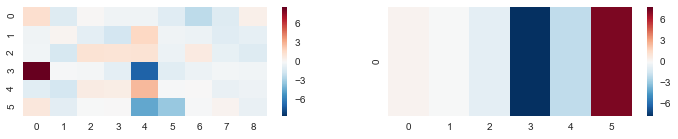

3, 0.10, -0.4027828875, -0.4110780367


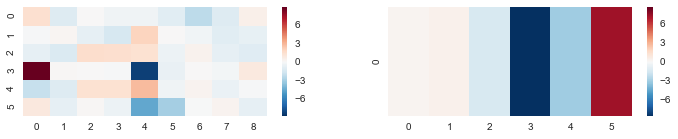

3, 0.10, -0.4508268570, -0.4186569213


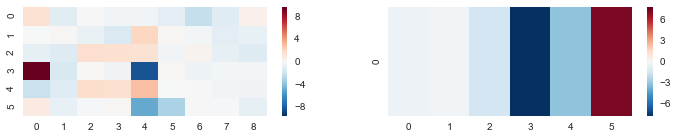

3, 0.10, -0.4367134983, -0.6163917042


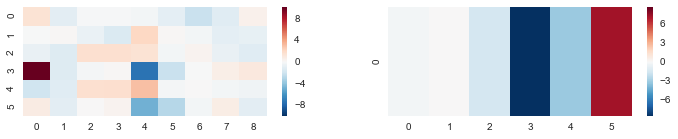

3, 0.10, -0.1310252292, -0.3087123782


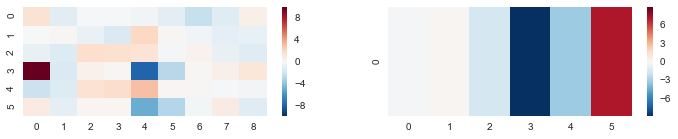

In [14]:
for _ in tqdm_notebook(range(10), desc="main_2"):
    mine_data(agent1, agent_random_action=0.1, **kvparams)

На первом слое: скорость, направление, лидары, руль, ускорение 

# Смотрим вживую

In [15]:
def visualize(agent, map_seed):
    agent.evaluate_mode=True
    print("visualize on map = {}".format(map_seed))
    agent.clear_history()
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=None, visual=True, save=False)

In [16]:
visualize(agent1, map_seed)

visualize on map = 3


# Отладка

In [ ]:
raise Exception("Здесь отладка")

In [ ]:
agent_dbg = agent2

In [ ]:
# prepare train data
X_train = np.concatenate([agent_dbg.sensor_data_history, agent_dbg.chosen_actions_history], axis=1)
y_train = np.array(agent_dbg.reward_history)
mean_train_revard = y_train.mean()
mean_train_revard

In [ ]:
len(y_train)

In [ ]:
- X_train.dot(np.diag([2.0, 1.0, 0.4] + [0.2] * (agent2.rays - 2) + [0.4, 1.0, 1.0])).mean(axis=0)

In [ ]:
agent2.neural_net.weights[0] = norm_weights
agent2.neural_net.biases[0] = norm_biases

In [ ]:


    y_train = np.pad(y_train, (0, 2 * REWARD_SHIFT), mode="constant")
    norm_reward_size = REWARD_SHIFT * (REWARD_SHIFT - 1) / 2
    y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * REWARD_SHIFT + i)] * i / norm_reward_size for i in range(1, REWARD_SHIFT+1)])

    #train NN
    train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]
    agent.neural_net.SGD(training_data=train_data,
                         epochs=40,
                         mini_batch_size=MINI_BATCH_SIZE,
                         eta=0.05)

    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"{map_seed}, {agent_random_action:.2f}, {mean_train_revard:.10f}, {mean_test_reward:.10f}"
    print(log_message)
    plt.figure(figsize=(12,2))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(agent.neural_net.weights[0])
    plt.subplot(1, 2, 2)
    ax = sns.heatmap(agent.neural_net.weights[1])
    plt.show()